In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import glob
import os
import fnmatch
import calendar

In [2]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# regional domain
ldom = np.array([[46.5,47.5],[-125.1,-124]])
# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 

#palette=plt.get_cmap("Spectral").reversed()
#palette=plt.get_cmap("YlGnBu").reversed()
#palette=plt.get_cmap("coolwarm").reversed()
palette=plt.get_cmap("RdYlGn")

In [3]:
#get bathymetry from ETOPO1
fn = '../data/ETOPO1_QIN.nc'
ds_topo = xr.open_dataset(fn)
ds_topo.close()
topo = ds_topo.z.sel(y=slice(ldom[0,0],ldom[0,1]),x=slice(ldom[1,0],ldom[1,1]))
X,Y=np.meshgrid(topo.x,topo.y)


In [4]:
# qin mask
qin = xr.open_dataset(ldp+'/QIN/qin_mask.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
qin = qin.where(qin!=0,np.nan)

# number of pixels in the mask
npx = qin.count(dim=['lat','lon']).values

In [5]:
fishdt = pd.read_csv('../data/QiN_dataspecifics.csv')
# https://docs.google.com/spreadsheets/d/1zYiVVgZR4DLksM_yABO_zPnsXe7Q6Uh_8tvxt3n60N0/edit?usp=sharing')
# Transform O2
fishdt['Om'] = fishdt['Om']/44.661
var = ['thetao','o2']   
depth = ['surface','bottom']
ssps = ['ssp245','ssp585']

In [6]:
def get_suitable_habitat_values(x, m, s, z):
    func = lambda x, m, s, z: z * np.exp(-0.5*((x - m)/s)**2)
    return xr.apply_ufunc(func, x, m, s, z)

def T_weighted_suitable_habitat(fishnum, ds_tmp):
    import math
    
    # generate mask for final tally
    mask1 = ds_tmp.where((ds_tmp>=fishdt['Tm'][fishnum])&(ds_tmp<=fishdt['Tx'][fishnum]), np.nan)*0 + 1
    mask2 = ds_tmp.where((ds_tmp<=fishdt['Tm'][fishnum])|(ds_tmp>=fishdt['Tx'][fishnum]), np.nan)*0
    mask = xr.concat((mask1,mask2),'z').mean(dim='z')
    #mask = ds_tmp.where((ds_tmp>=Trange[fishnum,0])&(ds_tmp<=Trange[fishnum,1]), np.nan)
    
    # define normal distribution for the t range and set values
    m = (fishdt['Tx'][fishnum]+fishdt['Tm'][fishnum])/2
    s = (fishdt['Tx'][fishnum]-fishdt['Tm'][fishnum])*0.68/2
    # scale to 0-1
    xw = np.arange(fishdt['Tm'][fishnum], fishdt['Tx'][fishnum], 0.01)
    z = 1/s/np.sqrt(2*math.pi)
    yw = z * np.exp(-0.5*((xw - m)/s)**2)
    ymin = yw.min()
    ymax = (yw-ymin).max()
    #ymax = yw.max()
    #plt.plot(xw, (yw-ymin)/ymax)
    #plt.show()
    
    ds_new = get_suitable_habitat_values(ds_tmp, m, s, z)
    ds_new = (ds_new - ymin)*100 / ymax
    #ds_new = (ds_new)*100 / ymax
    ds_new = ds_new * mask
    
    return ds_new
    

In [21]:
def suitable_habitat_pervar_allmod(fishnum, var):
    # decades to average
    yrsav = [*range(1990,2100,10)]
    
    for clim in ssps:
        for i2 in depth:
            # for the given variable at given depth
            tmp1 = np.full((len(qin.lat.values),len(qin.lon.values),len(yrsav),9),np.nan)
            # optimal range thresholds
            if var=='thetao':
                th1 = fishdt['Tm'][fishnum]
                th2 = fishdt['Tx'][fishnum]
            else:
                th1 = fishdt['Om'][fishnum]
            # for each model
            fns = glob.glob(ldp+'/QIN/downscaled_data/'+clim+'/'+var+'/'+i2+'/*.nc')
            # build datasets from all models
            for modn,fn in enumerate(fns):
                # model name
                tmps = fn.split('/')
                tmps2 = tmps[-1].split('_')
                modname = tmps2[0]+'_'+tmps2[1]
                #print(modn,models[nummod])
                ds_Ts = xr.open_dataset(fn)
                ds_Ts.close()
                ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
                # select only region of interest (large)
                ds_Ts = ds_Ts[var].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]),time=slice('1994-01-01','2099-12-31'))
                # mask qin region
                ds_Ts = ds_Ts*qin

                if var=='thetao':
                    # calculate suitable habitat for T
                    tmp = T_weighted_suitable_habitat(fishnum, ds_Ts)
                else:
                    tmp = ds_Ts.where(ds_Ts>=th1)
                    #tmp = tmp*qin

                # data array
                if modn==0:
                    fechas = ds_Ts.time
                tmp_ds = xr.DataArray(data=tmp,dims=['time','lat','lon'],
                                    coords=dict(time=fechas,lat=ds_Ts.lat,lon=ds_Ts.lon))
                # suitable habitat
                if var=='thetao':
                    Sh_tmp = tmp_ds.mean(dim=['lat','lon']).values
                else:
                    Sh_tmp = (tmp_ds.count(dim=['lat','lon']).values)*100/npx
                    
                tmp = xr.DataArray(data=Sh_tmp, dims=['time'], coords=dict(time=fechas))
                
                if modn==0: 
                    allmod = xr.Dataset({modname:tmp})
                else:
                    allmod[modname] = tmp
            
            varns = clim+'_'+i2
            allmod.to_netcdf(ldp+'QIN/downscaled_data/suitable_habitat_v2/'+var+'_'+fishdt['Species'][fishnum]+'_'+varns+'_allmods.nc')

In [22]:
for fishn in range(len(fishdt)):
    suitable_habitat_pervar_allmod(fishn,'thetao')
    suitable_habitat_pervar_allmod(fishn,'o2')

In [23]:
def plot_decadal_timseries_ensemble(fishnum, dp, varn,ssp):
    ds = xr.open_dataset(ldp+'QIN/downscaled_data/suitable_habitat_v2/'+varn+'_'+fishdt['Species'][fishnum]+'_'+ssp+'_'+dp+'_allmods.nc')
    ds.close()

    yrsav = [*range(1990,2101,10)]
    yrs = ds.time.dt.year.values
    Sh_Ts_dec = np.full((len(yrsav)-1,len(list(ds))),np.nan)
    for idx,i in enumerate(list(ds)):
        for j in range(len(yrsav)-1):
            a=(yrs>=yrsav[j])&(yrs<=yrsav[j+1])
            tmp = ds[i].values
            Sh_Ts_dec[j,idx] = np.nanmean(tmp[a])

    plt.figure(figsize=(8,4))
    plt.plot(yrsav[:-1], Sh_Ts_dec,'.-',c='grey', alpha=0.6,zorder=1)
    plt.errorbar(yrsav[:-1], np.nanmean(Sh_Ts_dec, axis=1), yerr=np.nanstd(Sh_Ts_dec, axis=1),c='tab:red', lw=3, zorder=2)
    plt.grid(True, alpha=0.3, zorder=0)
    plt.title(fishdt['Species'][fishnum]+', '+dp+', '+varn+', '+ssp)
    plt.ylabel('Suitable Habitat (%)')
    plt.ylim([0,100])
    plt.show()

In [24]:
def plot_decadal_hovmuller_ensemble(fishnum, dp, varn, ssp):
    # plot hovmuller
    ds = xr.open_dataset(ldp+'QIN/downscaled_data/suitable_habitat_v2/'+varn+'_'+fishdt['Species'][fishnum]+'_'+ssp+'_'+dp+'_allmods.nc')
    ds.close()

    yrsav = [*range(1990,2101,10)]
    yrs = np.unique(ds.time.dt.year.values)
    Sh_Ts_dec_hv = np.full((len(yrsav)-1,12,len(list(ds))),np.nan)

    for idx,i in enumerate(list(ds)): # for each model
        tmp = ds[i].values
        tmp = tmp.reshape((int(len(tmp)/12)), 12)
        for j in range(len(yrsav)-1): # for each decade
            a=(yrs>=yrsav[j])&(yrs<=yrsav[j+1])
            for k in range(12):
                Sh_Ts_dec_hv[j,k,idx] = np.nanmean(tmp[a,k])

    Sh_Ts_dec_hvm = np.full((12,len(yrsav)-1),np.nan)
    Sh_Ts_dec_hvs = np.full((12,len(yrsav)-1,),np.nan)
    for j in range(len(yrsav)-1):
        for i in range(12):
            Sh_Ts_dec_hvm[i,j] = np.nanmedian(Sh_Ts_dec_hv[j,i,:])
            Sh_Ts_dec_hvs[i,j] = np.nanstd(Sh_Ts_dec_hv[j,i,:])

    plt.figure(figsize=(10,4))
    if varn=='thetao':
        ax=sns.heatmap(Sh_Ts_dec_hvm, yticklabels=months, xticklabels=yrsav[:-1], linewidths=0, alpha=0.8,cmap="coolwarm_r", vmin=0, vmax=100)
    else:
        ax=sns.heatmap(Sh_Ts_dec_hvm, yticklabels=months, xticklabels=yrsav[:-1], linewidths=0, alpha=0.8,cmap="YlGnBu_r", vmin=0, vmax=100)
    X2, Y2 = np.meshgrid(np.arange(0.5,len(yrsav[:-1])),np.arange(0.5,12))
    plt.scatter(X2, Y2, s=Sh_Ts_dec_hvs,c='w',marker='o', edgecolor='grey', alpha=0.6)
    plt.title(fishdt['Species'][fishnum]+', '+dp+', '+varn+', '+ssp)
    plt.show()
    

Dungeness Crab thetao


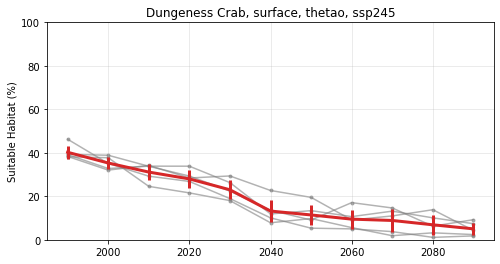

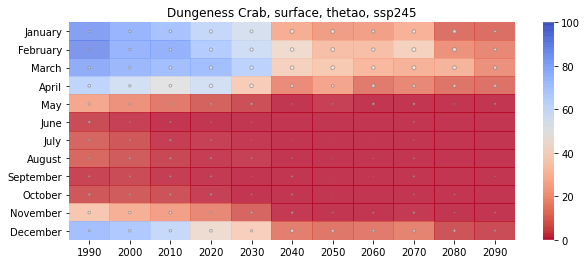

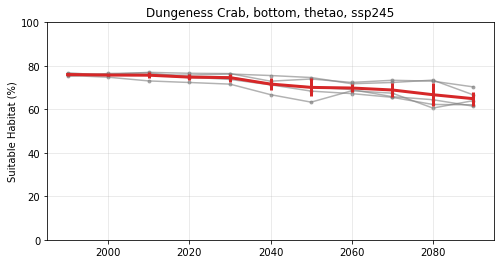

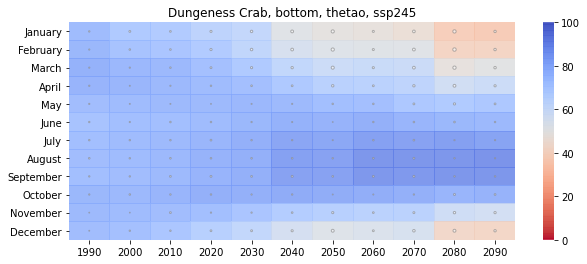

Dungeness Crab o2


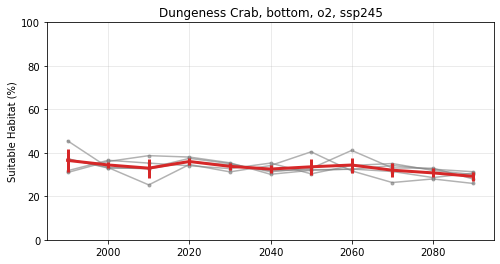

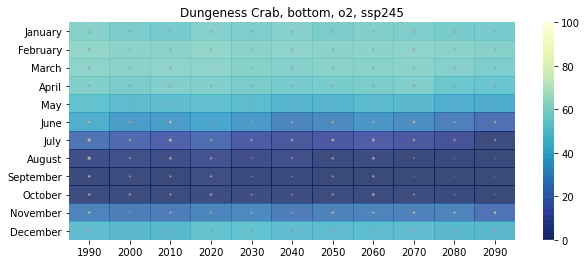

Sablefish thetao


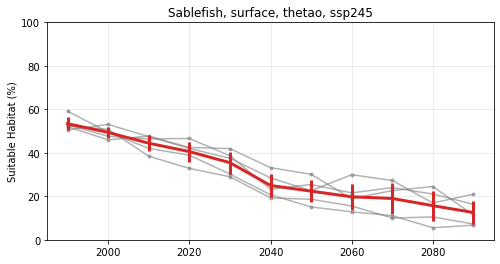

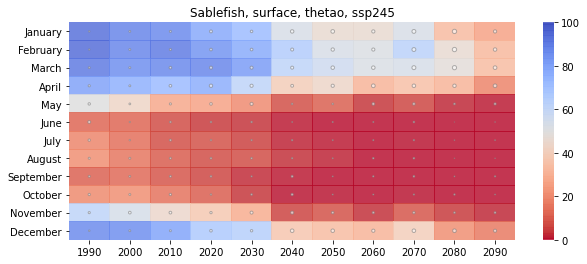

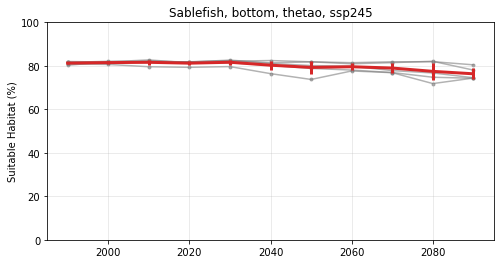

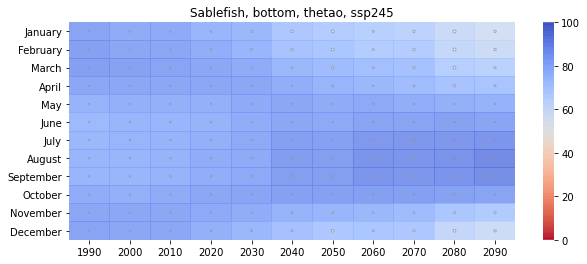

Sablefish o2


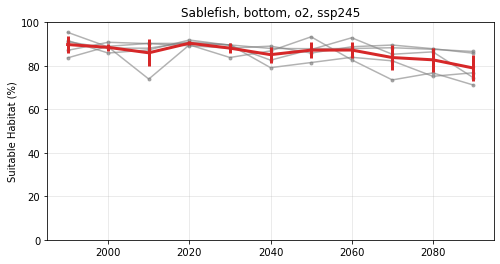

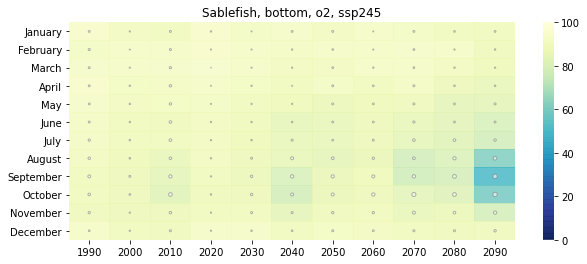

P. Halibut thetao


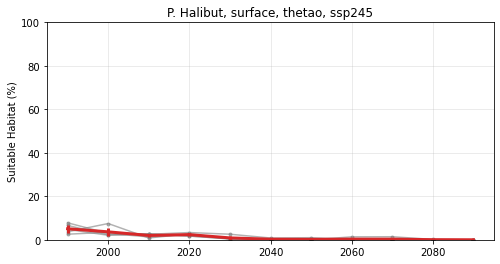

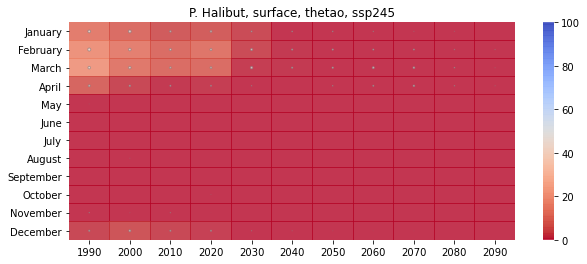

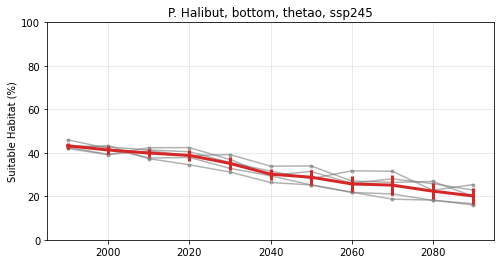

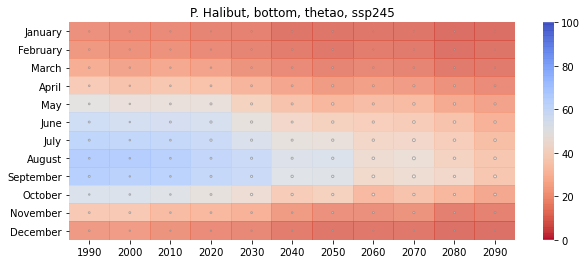

P. Halibut o2


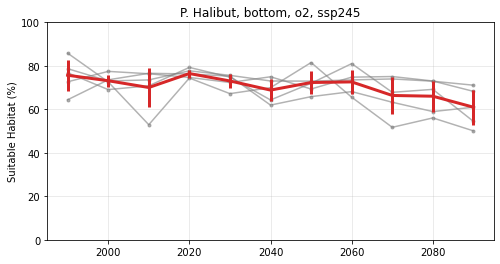

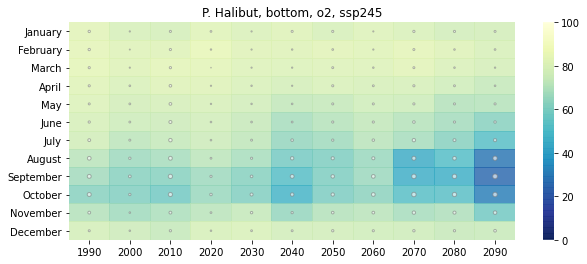

Chinook thetao


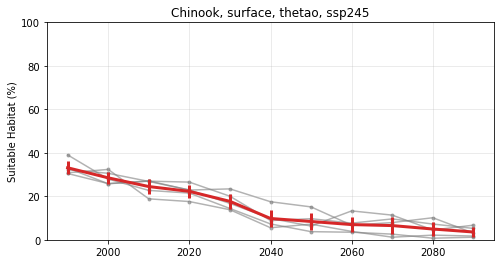

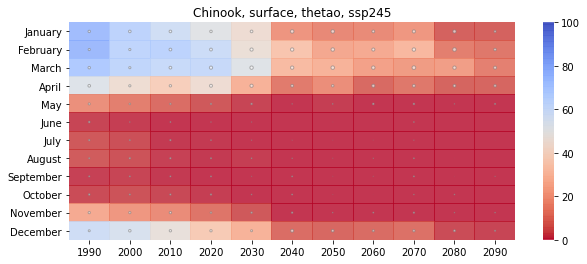

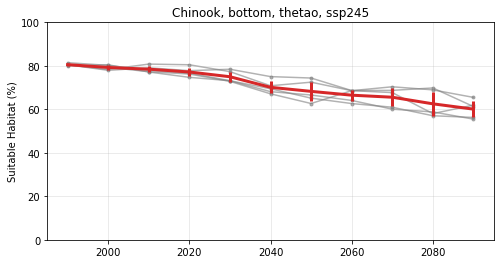

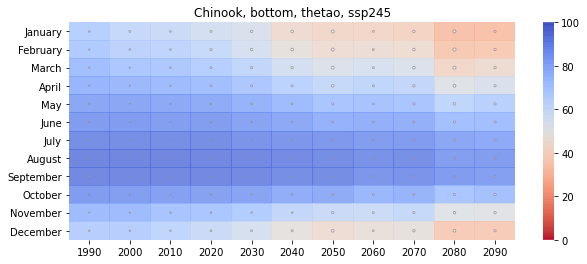

Chinook o2


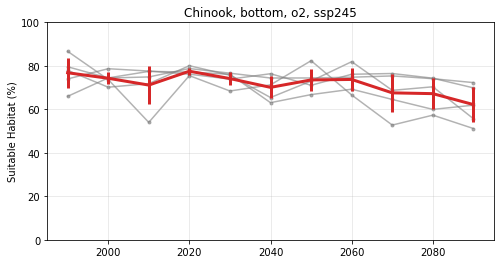

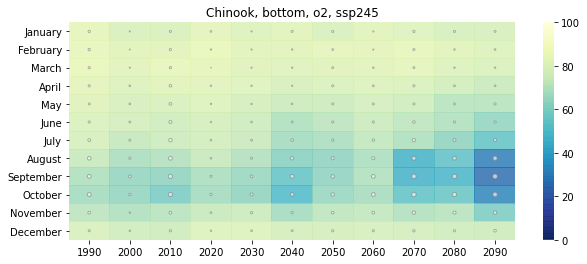

Coho thetao


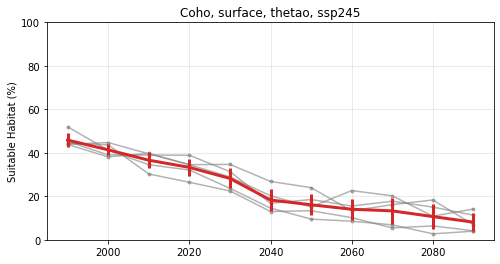

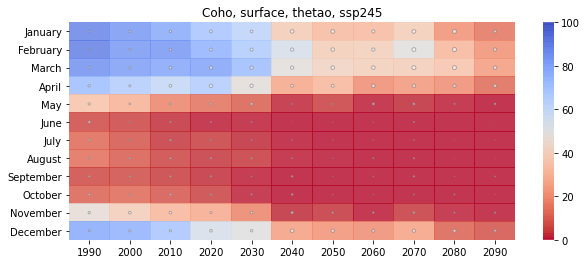

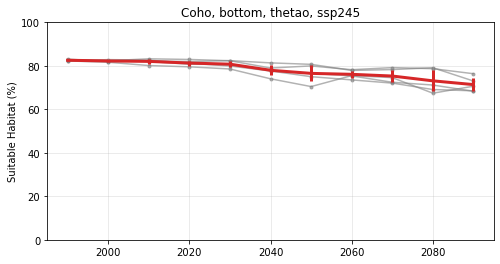

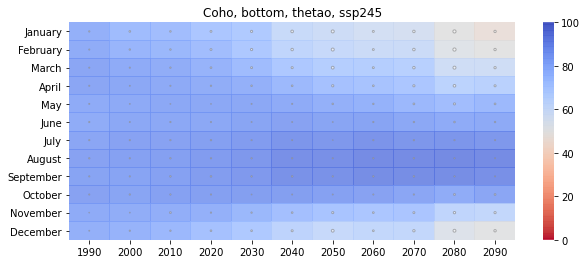

Coho o2


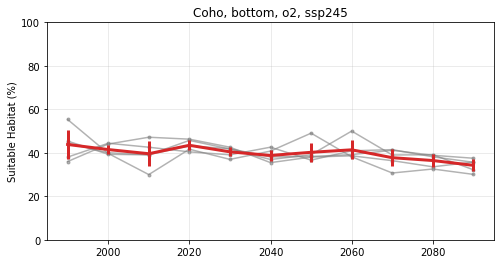

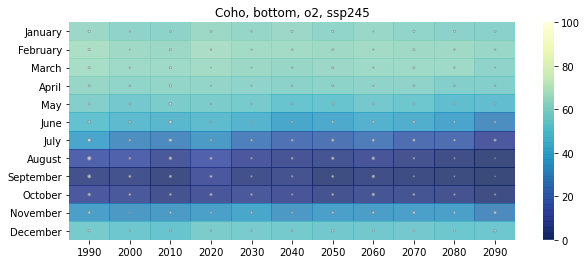

Razor Clams thetao


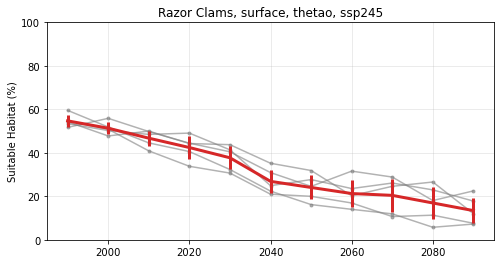

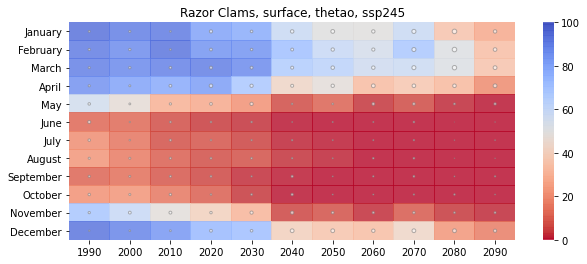

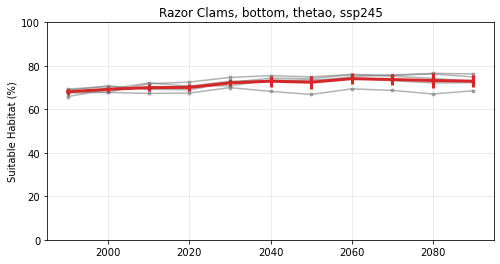

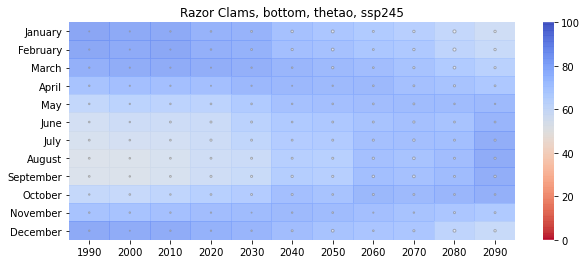

Razor Clams o2


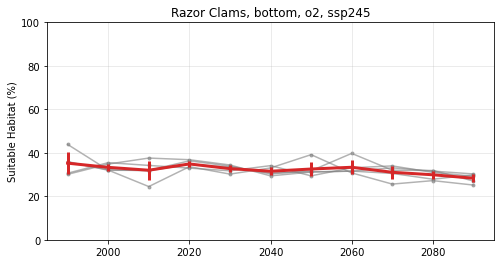

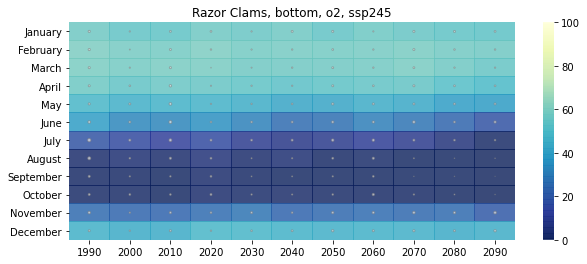

Albacore thetao


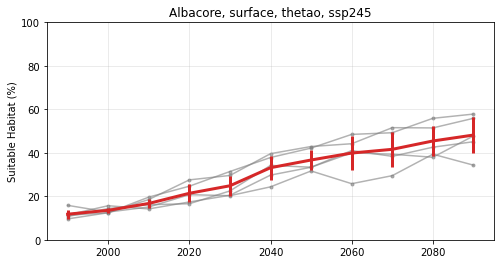

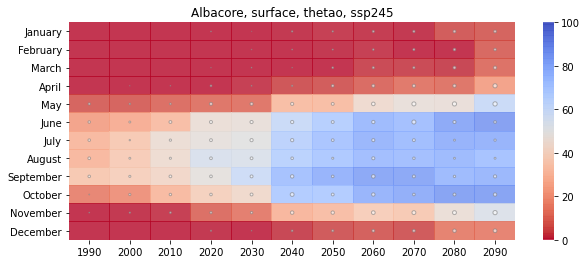

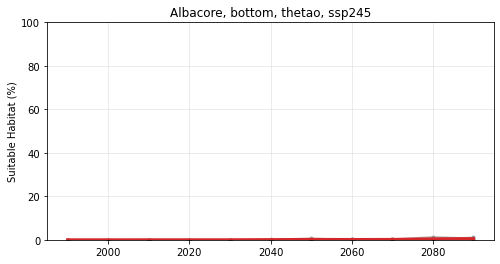

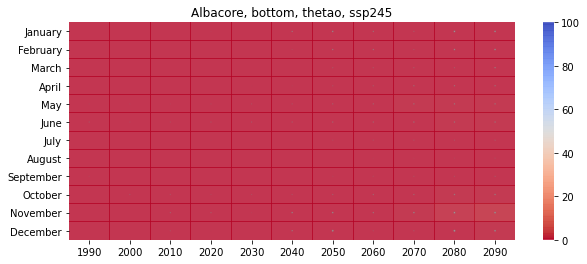

Albacore o2


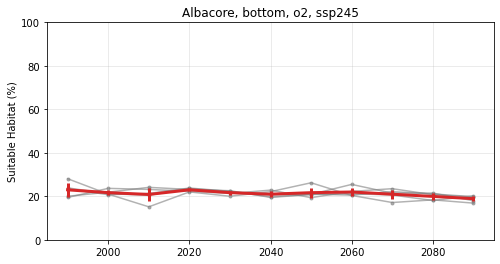

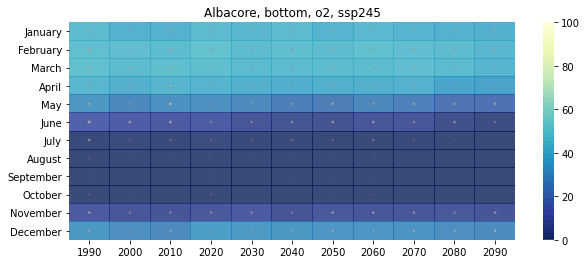

Dungeness Crab thetao


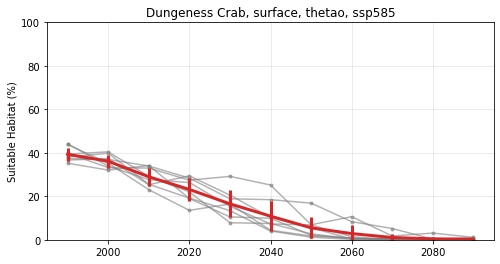

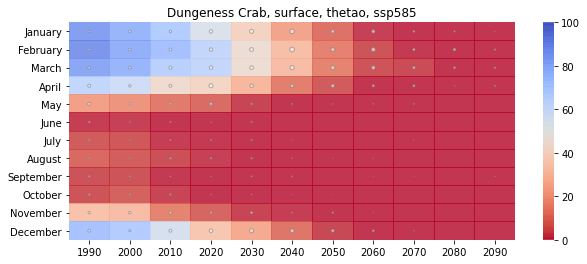

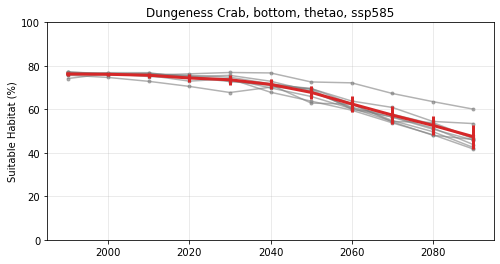

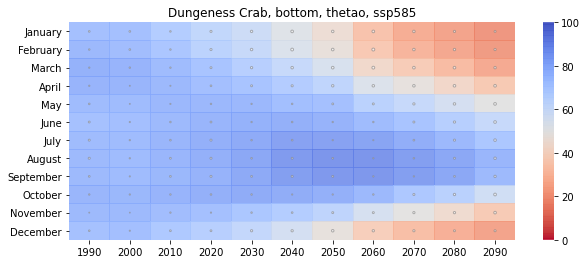

Dungeness Crab o2


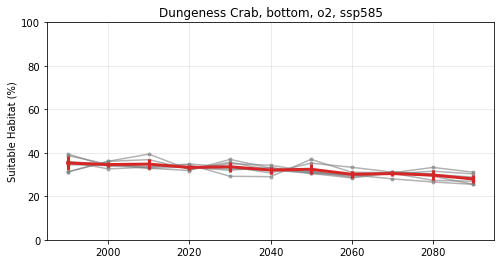

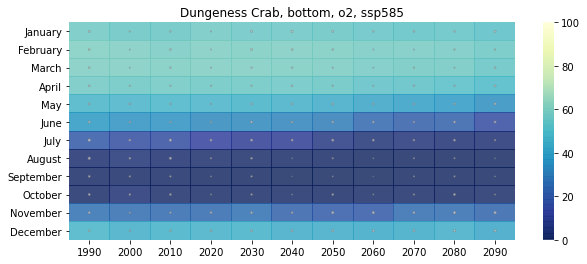

Sablefish thetao


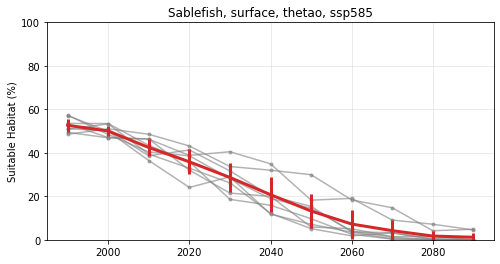

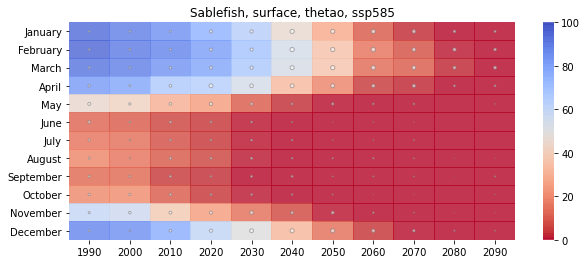

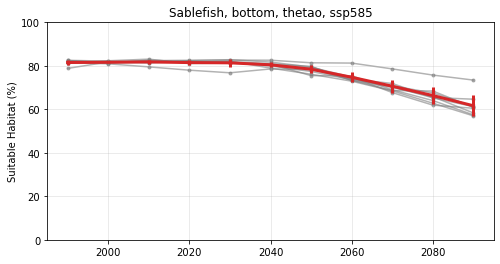

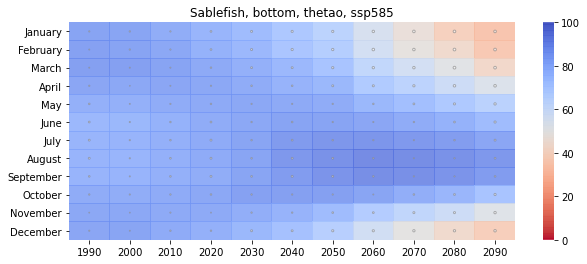

Sablefish o2


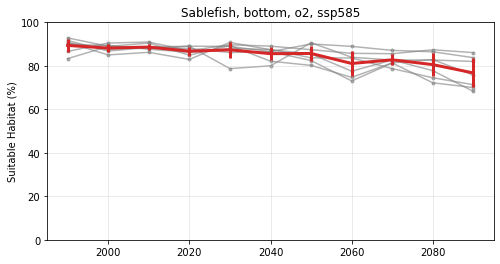

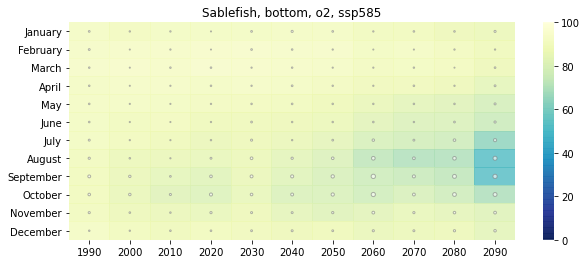

P. Halibut thetao


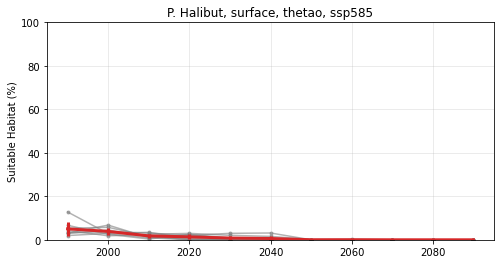

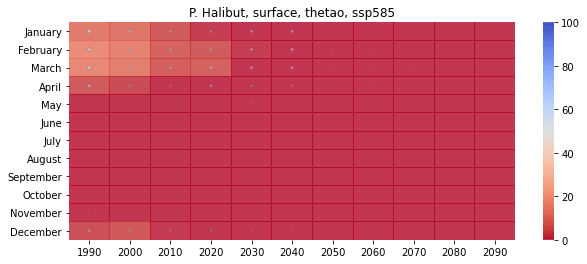

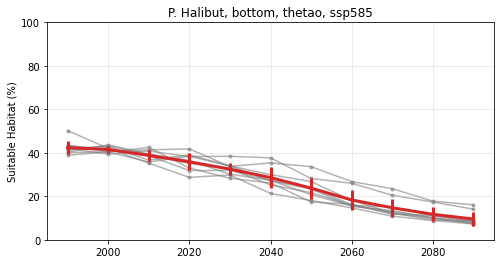

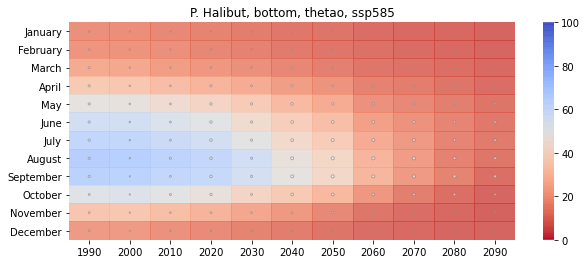

P. Halibut o2


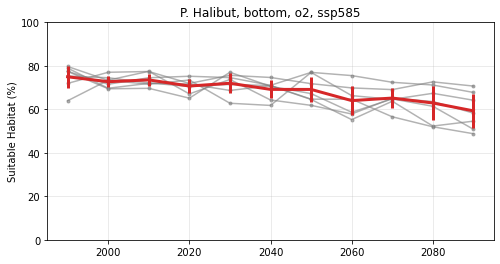

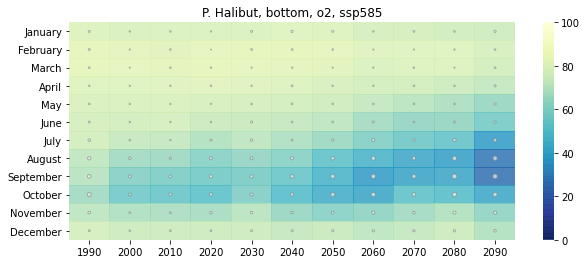

Chinook thetao


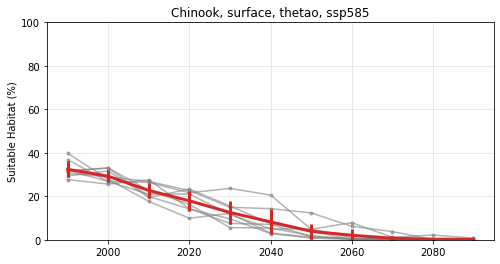

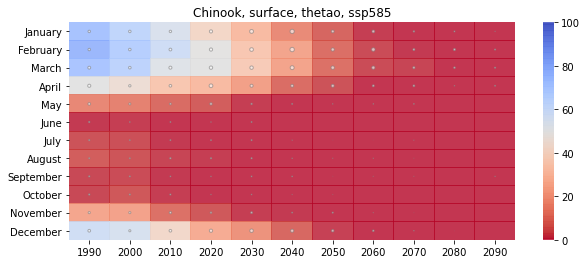

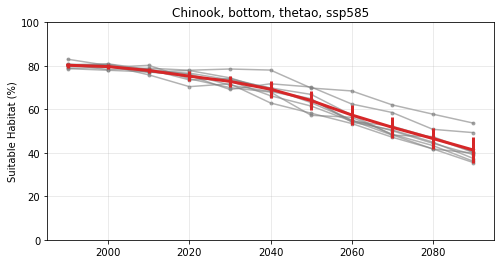

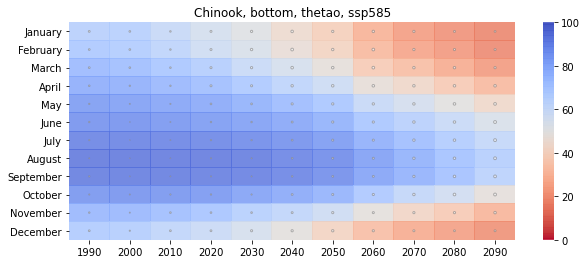

Chinook o2


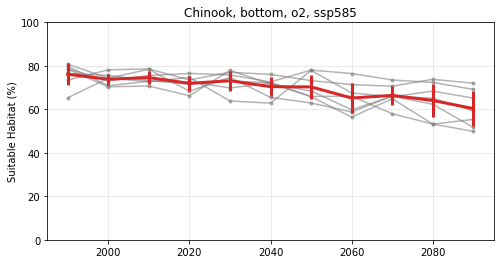

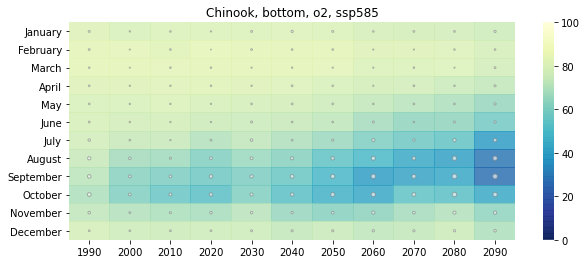

Coho thetao


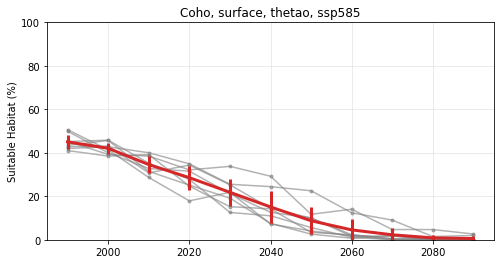

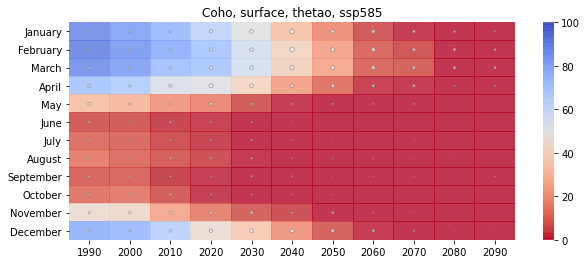

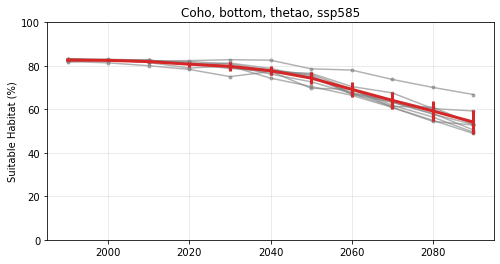

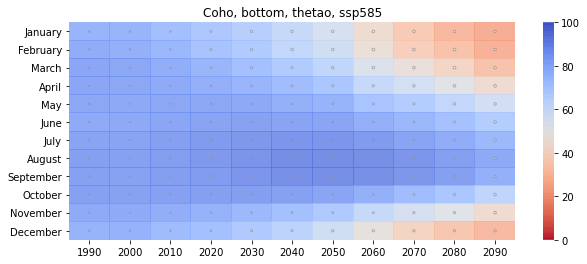

Coho o2


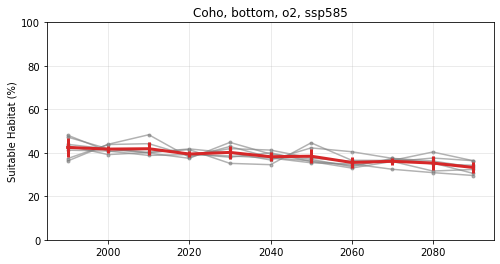

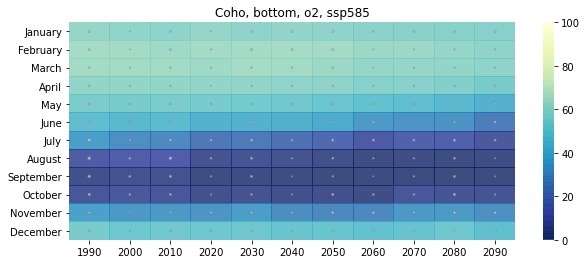

Razor Clams thetao


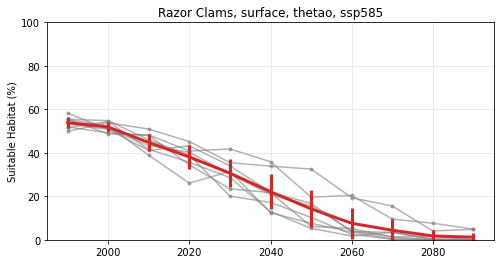

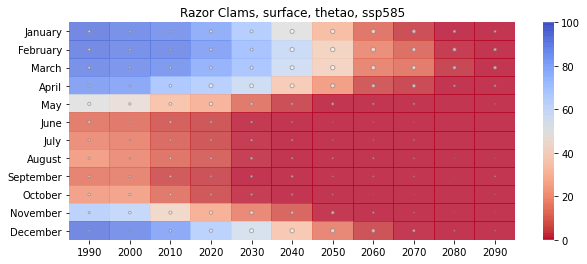

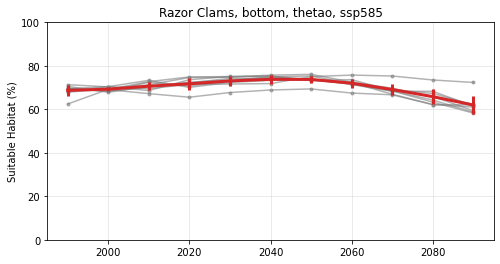

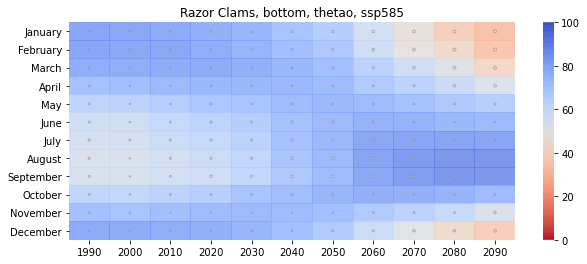

Razor Clams o2


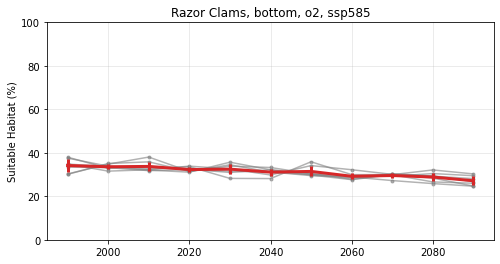

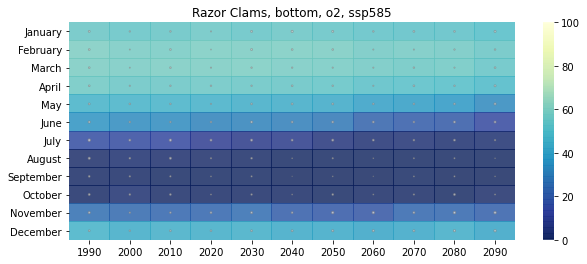

Albacore thetao


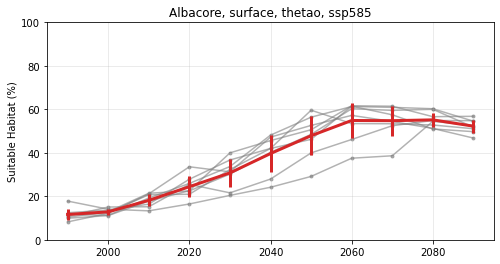

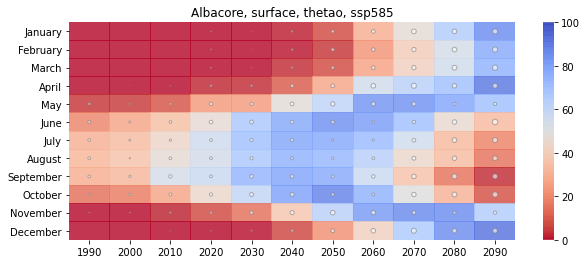

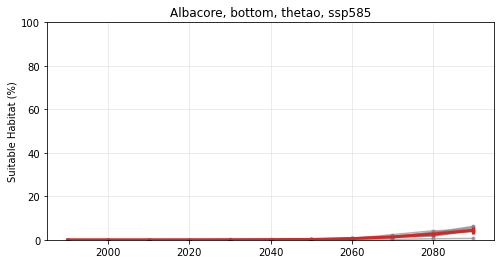

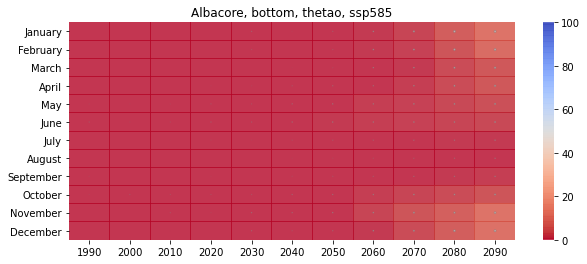

Albacore o2


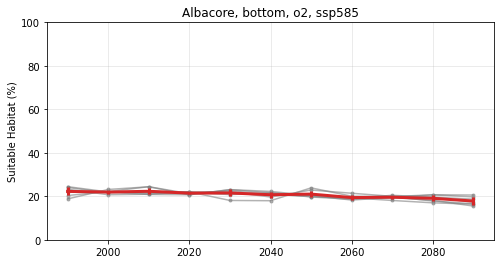

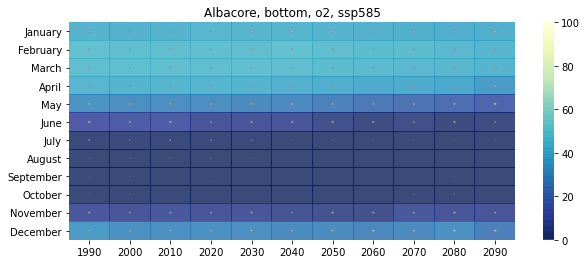

In [25]:
for scenario in ssps:
    for fishn in range(len(fishdt)):
        for vari in var:
            print(fishdt['Species'][fishn],vari)
            if vari=='thetao':
                for dp in depth:
                    plot_decadal_timseries_ensemble(fishn, dp, vari, scenario)
                    plot_decadal_hovmuller_ensemble(fishn, dp, vari, scenario)
            else:
                plot_decadal_timseries_ensemble(fishn, 'bottom', vari, scenario)
                plot_decadal_hovmuller_ensemble(fishn, 'bottom', vari, scenario)
